<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>F1 Predictor</h1><h2> </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

In [1]:
# import the packages
# Importing the packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# for Q-Q plots
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import MeanEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.imputation import RandomSampleImputer
from feature_engine.transformation import ReciprocalTransformer
from feature_engine.transformation import PowerTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import BoxCoxTransformer

#Encoders
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import OrdinalEncoder
from feature_engine.encoding import MeanEncoder
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.encoding import RareLabelEncoder

#Discretisers
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

#Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.preprocessing import RobustScaler


pd.set_option('display.float_format', lambda x: '%.5f' % x) #suppressing scientific notation



### Step 1: Load and Explore the Data

In [2]:
drivers = pd.read_csv('drivers_mod.csv')
lap_time = pd.read_csv('lap_times_mod.csv')
pitstop = pd.read_csv('pit_stops_mod.csv')
races = pd.read_csv('races_mod.csv')
results = pd.read_csv('results_mod.csv')
status = pd.read_csv('status_mod.csv')
circuits = pd.read_csv('circuits_mod.csv')


### Step 2: Data Wrangling on multiple tables 

#### Merging of tables

In [4]:
# Drop columns that will not help with prediction
drivers = drivers.drop(['url','code'],axis=1)
races = races.drop(['url','name','time'],axis=1)
results = results.drop(['positionText','positionOrder','time','points','number','fastestLap','fastestLapTime','fastestLapSpeed'],axis=1)
lap_time= lap_time.drop(['position','time','lap'],axis=1)
pitstop = pitstop.drop(['lap','time','duration'],axis=1)
circuits = circuits.drop(['circuitRef','name','location','lat','lng','alt','url'],axis=1)

In [5]:
#getting the year from race date 
races['date'] = races['date'].str[-4:] 

#date data is always missing for either the first round or the middle rounds. Thus we fill them with following round's date
races['date'] = races['date'].bfill() 

races.head(30)

,raceId,round,circuitId,date
0,1,1,1,2009
1,2,2,2,2009
2,3,3,17,2009
3,4,4,3,2009
4,5,5,4,2009
5,6,6,6,2009
6,7,7,5,2009
7,8,8,9,2009
8,9,9,20,2009
9,10,10,11,2009


In [6]:
# merging results with races table
df = results.merge(races,on='raceId',how='inner')
df

,resultId,raceId,driverId,constructorId,grid,position,laps,milliseconds,rank,statusId,round,circuitId,date
0,1,18,1,1,1,1,58,5690616,2,1,1,1,2008
1,2,18,2,2,5,2,58,5696094,3,1,1,1,2008
2,3,18,3,3,7,3,58,5698779,5,1,1,1,2008
3,4,18,4,4,11,4,58,5707797,7,1,1,1,2008
4,5,18,5,1,3,5,58,5708630,1,1,1,1,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25394,25400,1073,815,9,4,15,55,\N,2,5,22,24,2021
25395,25401,1073,849,3,16,\N,50,\N,15,3,22,24,2021
25396,25402,1073,841,51,14,\N,33,\N,16,6,22,24,2021
25397,25403,1073,847,3,17,\N,26,\N,19,6,22,24,2021


In [7]:
#merging drivers table with previously joint table
df = df.merge(drivers,on = 'driverId',how='inner')
df

,resultId,raceId,driverId,constructorId,grid,position,laps,milliseconds,rank,statusId,round,circuitId,date,driverRef,number,forename,surname,dob,nationality
0,1,18,1,1,1,1,58,5690616,2,1,1,1,2008,hamilton,44,Lewis,Hamilton,1985-01-07,British
1,27,19,1,1,9,5,56,5525103,3,1,2,2,2008,hamilton,44,Lewis,Hamilton,1985-01-07,British
2,57,20,1,1,3,13,56,\N,19,11,3,3,2008,hamilton,44,Lewis,Hamilton,1985-01-07,British
3,69,21,1,1,5,3,66,5903238,3,1,4,4,2008,hamilton,44,Lewis,Hamilton,1985-01-07,British
4,90,22,1,1,3,2,58,5213230,2,1,5,5,2008,hamilton,44,Lewis,Hamilton,1985-01-07,British
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25394,25302,1069,853,210,17,17,54,\N,20,12,17,69,2021,mazepin,9,Nikita,Mazepin,1999-03-02,Russian
25395,25323,1070,853,210,15,18,68,\N,15,13,18,32,2021,mazepin,9,Nikita,Mazepin,1999-03-02,Russian
25396,25342,1071,853,210,19,17,69,\N,19,12,19,18,2021,mazepin,9,Nikita,Mazepin,1999-03-02,Russian
25397,25363,1051,853,210,20,18,55,\N,16,12,20,78,2021,mazepin,9,Nikita,Mazepin,1999-03-02,Russian


In [8]:
#merging circuits table with previously joint table
df =df.merge(circuits,on='circuitId',how='inner')
df

,resultId,raceId,driverId,constructorId,grid,position,laps,milliseconds,rank,statusId,round,circuitId,date,driverRef,number,forename,surname,dob,nationality,country
0,1,18,1,1,1,1,58,5690616,2,1,1,1,2008,hamilton,44,Lewis,Hamilton,1985-01-07,British,Australia
1,371,36,1,1,4,3,58,5147365,3,1,1,1,2007,hamilton,44,Lewis,Hamilton,1985-01-07,British,Australia
2,7573,1,1,1,18,\N,58,\N,13,2,1,1,2009,hamilton,44,Lewis,Hamilton,1985-01-07,British,Australia
3,20352,338,1,1,11,6,58,5646429,3,1,2,1,2010,hamilton,44,Lewis,Hamilton,1985-01-07,British,Australia
4,20780,841,1,1,2,2,58,5392556,8,1,1,1,2011,hamilton,44,Lewis,Hamilton,1985-01-07,British,Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25394,20009,832,697,51,8,5,68,\N,\N,12,8,67,1951,bonetto,\N,Felice,Bonetto,1903-06-09,Italian,Spain
25395,20021,832,704,154,14,\N,7,\N,\N,3,8,67,1951,cabantous,\N,Yves,Cabantous,1904-10-08,French,Spain
25396,20012,832,741,154,13,8,63,\N,\N,17,8,67,1951,etancelin,\N,Philippe,Étancelin,1896-12-28,French,Spain
25397,20020,832,783,154,16,\N,23,\N,\N,5,8,67,1951,grignard,\N,Georges,Grignard,1905-07-25,French,Spain


#### Creation of new columns

In [9]:
#creating new column for the average lap time of each driver for each race
avg = lap_time.groupby(['raceId','driverId'])['milliseconds'].mean()
avg_lap_time  = avg.reset_index()
avg_lap_time = avg_lap_time.rename({'milliseconds':'avg_lap_time'},axis=1)
avg_lap_time

,raceId,driverId,avg_lap_time
0,1,1,97563.75862
1,1,2,97635.67241
2,1,3,97612.17241
3,1,4,97597.63793
4,1,6,91822.23529
...,...,...,...
9712,1073,846,94423.18966
9713,1073,847,95032.88462
9714,1073,849,92309.82000
9715,1073,852,93500.63793


In [10]:
#creating new column for the number of stops made by the driver for each race
no_stops = pitstop.groupby(['raceId','driverId'])['stop'].count()
no_stops = no_stops.reset_index()
no_stops = no_stops.rename({'stop':'no_stops'},axis=1)
no_stops.head(10)


,raceId,driverId,no_stops
0,841,1,2
1,841,2,2
2,841,3,1
3,841,4,3
4,841,5,1
5,841,10,1
6,841,13,3
7,841,15,2
8,841,16,2
9,841,17,3


In [11]:
#new column for the average stop time for driver per race
avg_stop_time = pitstop.groupby(['raceId','driverId'])['milliseconds'].mean()
avg_stop_time = avg_stop_time.reset_index()
avg_stop_time = avg_stop_time.rename({'milliseconds':'avg_stoptime'},axis=1)
avg_stop_time.head(10)

,raceId,driverId,avg_stoptime
0,841,1,23213.00000
1,841,2,24046.00000
2,841,3,23716.00000
3,841,4,24055.00000
4,841,5,24865.00000
5,841,10,23792.00000
6,841,13,24145.66667
7,841,15,24873.50000
8,841,16,24924.50000
9,841,17,24058.66667


In [12]:
#merging avg_lap_time with the previously joint table
df = df.merge(avg_lap_time,on=['raceId','driverId'],how ='inner')
df = df.merge(no_stops,on=['raceId','driverId'], how ='inner')
df = df.merge(avg_stop_time,on=['raceId','driverId'], how ='inner')
df

,resultId,raceId,driverId,constructorId,grid,position,laps,milliseconds,rank,statusId,...,driverRef,number,forename,surname,dob,nationality,country,avg_lap_time,no_stops,avg_stoptime
0,20780,841,1,1,2,2,58,5392556,8,1,...,hamilton,44,Lewis,Hamilton,1985-01-07,British,Australia,92975.10345,2,23213.00000
1,21234,860,1,1,1,3,58,5653640,4,1,...,hamilton,44,Lewis,Hamilton,1985-01-07,British,Australia,97476.55172,2,23163.00000
2,21716,880,1,131,3,5,58,5448786,5,1,...,hamilton,44,Lewis,Hamilton,1985-01-07,British,Australia,93944.58621,3,21982.66667
3,22538,926,1,131,1,99,58,5514067,1,1,...,hamilton,44,Lewis,Hamilton,1985-01-07,British,Australia,95070.12069,1,22295.00000
4,22918,948,1,131,1,2,57,6503625,4,1,...,hamilton,44,Lewis,Hamilton,1985-01-07,British,Australia,114098.68421,2,556013.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4286,25375,1072,846,1,7,10,50,7636476,8,1,...,norris,4,Lando,Norris,1999-11-13,British,Saudi Arabia,152729.52000,3,718284.00000
4287,25384,1072,847,3,14,\N,14,\N,19,4,...,russell,63,George,Russell,1998-02-15,British,Saudi Arabia,194902.85714,2,521067.00000
4288,25377,1072,849,3,16,12,50,7658367,12,1,...,latifi,6,Nicholas,Latifi,1995-06-29,Canadian,Saudi Arabia,153167.34000,3,716176.33333
4289,25379,1072,852,213,8,14,49,\N,10,11,...,tsunoda,22,Yuki,Tsunoda,2000-05-11,Japanese,Saudi Arabia,155069.36735,3,711641.66667


In [13]:
#dropping of irrelevent columns that wont help with prediction
df = df.drop(['driverId','resultId','raceId','constructorId','round','circuitId','driverRef','number'],axis=1)
df.info()
#statusId is kept as it correlates to the performance of the driver

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4291 entries, 0 to 4290
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   grid          4291 non-null   int64  
 1   position      4291 non-null   object 
 2   laps          4291 non-null   int64  
 3   milliseconds  4291 non-null   object 
 4   rank          4291 non-null   object 
 5   statusId      4291 non-null   int64  
 6   date          4291 non-null   object 
 7   forename      4291 non-null   object 
 8   surname       4291 non-null   object 
 9   dob           4291 non-null   object 
 10  nationality   4291 non-null   object 
 11  country       4291 non-null   object 
 12  avg_lap_time  4291 non-null   float64
 13  no_stops      4291 non-null   int64  
 14  avg_stoptime  4291 non-null   float64
dtypes: float64(2), int64(4), object(9)
memory usage: 536.4+ KB


In [14]:
# dropping time taken for race - milliseconds, column is too correlated.
df =df.drop(['milliseconds'],axis=1)

In [15]:
#creating new column for the driver's name
df['driver_name']= df['forename'] +' '+ df['surname']


In [16]:
df = df.drop(['forename','surname'],axis=1)
df

,grid,position,laps,rank,statusId,date,dob,nationality,country,avg_lap_time,no_stops,avg_stoptime,driver_name
0,2,2,58,8,1,2011,1985-01-07,British,Australia,92975.10345,2,23213.00000,Lewis Hamilton
1,1,3,58,4,1,2012,1985-01-07,British,Australia,97476.55172,2,23163.00000,Lewis Hamilton
2,3,5,58,5,1,2013,1985-01-07,British,Australia,93944.58621,3,21982.66667,Lewis Hamilton
3,1,99,58,1,1,2015,1985-01-07,British,Australia,95070.12069,1,22295.00000,Lewis Hamilton
4,1,2,57,4,1,2016,1985-01-07,British,Australia,114098.68421,2,556013.50000,Lewis Hamilton
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4286,7,10,50,8,1,2021,1999-11-13,British,Saudi Arabia,152729.52000,3,718284.00000,Lando Norris
4287,14,\N,14,19,4,2021,1998-02-15,British,Saudi Arabia,194902.85714,2,521067.00000,George Russell
4288,16,12,50,12,1,2021,1995-06-29,Canadian,Saudi Arabia,153167.34000,3,716176.33333,Nicholas Latifi
4289,8,14,49,10,11,2021,2000-05-11,Japanese,Saudi Arabia,155069.36735,3,711641.66667,Yuki Tsunoda


In [17]:
#creating new column "driver_age" as there's correlation between age and probability of winning
df['driver_age'] = df['date'].astype('int')-df['dob'].str[:4].astype('int')

In [18]:
df = df.drop(['date','dob'],axis=1) #dropping since they have no use for prediction

In [19]:
df['position'].value_counts()

\N    457
2     217
5     217
11    217
4     217
7     217
8     217
9     217
3     217
6     216
10    216
12    216
13    213
14    207
15    197
16    177
1     172
17    153
18    115
19     79
20     46
99     45
21     26
22     14
23      5
24      1
Name: position, dtype: int64

In [20]:
#convert postions to 1 for values of 99 as 99 is considered first place (they are misidentified)
df['position'] =df['position'].replace('99','1')
df['position'].value_counts()

\N    457
2     217
9     217
5     217
1     217
4     217
7     217
8     217
11    217
3     217
12    216
10    216
6     216
13    213
14    207
15    197
16    177
17    153
18    115
19     79
20     46
21     26
22     14
23      5
24      1
Name: position, dtype: int64

In [21]:
#getting rid of disqualified racers
df.drop(df[df['statusId'] == 2 ].index,inplace=True)

In [22]:
# Creation of target variable where 1 =winner and 0 = loser (winner = postions up to 8)
df['result'] = [1 if x in ['1','2','3','4','5','6','7','8'] else 0 for x in df['position']]

In [23]:
df = df.drop(['position'],axis=1)
df

,grid,laps,rank,statusId,nationality,country,avg_lap_time,no_stops,avg_stoptime,driver_name,driver_age,result
0,2,58,8,1,British,Australia,92975.10345,2,23213.00000,Lewis Hamilton,26,1
1,1,58,4,1,British,Australia,97476.55172,2,23163.00000,Lewis Hamilton,27,1
2,3,58,5,1,British,Australia,93944.58621,3,21982.66667,Lewis Hamilton,28,1
3,1,58,1,1,British,Australia,95070.12069,1,22295.00000,Lewis Hamilton,30,1
4,1,57,4,1,British,Australia,114098.68421,2,556013.50000,Lewis Hamilton,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4286,7,50,8,1,British,Saudi Arabia,152729.52000,3,718284.00000,Lando Norris,22,0
4287,14,14,19,4,British,Saudi Arabia,194902.85714,2,521067.00000,George Russell,23,0
4288,16,50,12,1,Canadian,Saudi Arabia,153167.34000,3,716176.33333,Nicholas Latifi,26,0
4289,8,49,10,11,Japanese,Saudi Arabia,155069.36735,3,711641.66667,Yuki Tsunoda,21,0


In [24]:
df['result'].value_counts()

0    2547
1    1735
Name: result, dtype: int64

In [25]:
#for easier identification
df = df.rename({'country':'race_location','nationality':'driver_origin'},axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4282 entries, 0 to 4290
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   grid           4282 non-null   int64  
 1   laps           4282 non-null   int64  
 2   rank           4282 non-null   object 
 3   statusId       4282 non-null   int64  
 4   driver_origin  4282 non-null   object 
 5   race_location  4282 non-null   object 
 6   avg_lap_time   4282 non-null   float64
 7   no_stops       4282 non-null   int64  
 8   avg_stoptime   4282 non-null   float64
 9   driver_name    4282 non-null   object 
 10  driver_age     4282 non-null   int32  
 11  result         4282 non-null   int64  
dtypes: float64(2), int32(1), int64(5), object(4)
memory usage: 418.2+ KB


In [27]:
#changing data types
df['statusId'] = df['statusId'].astype('object')


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4282 entries, 0 to 4290
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   grid           4282 non-null   int64  
 1   laps           4282 non-null   int64  
 2   rank           4282 non-null   object 
 3   statusId       4282 non-null   object 
 4   driver_origin  4282 non-null   object 
 5   race_location  4282 non-null   object 
 6   avg_lap_time   4282 non-null   float64
 7   no_stops       4282 non-null   int64  
 8   avg_stoptime   4282 non-null   float64
 9   driver_name    4282 non-null   object 
 10  driver_age     4282 non-null   int32  
 11  result         4282 non-null   int64  
dtypes: float64(2), int32(1), int64(4), object(5)
memory usage: 418.2+ KB


In [29]:
df

,grid,laps,rank,statusId,driver_origin,race_location,avg_lap_time,no_stops,avg_stoptime,driver_name,driver_age,result
0,2,58,8,1,British,Australia,92975.10345,2,23213.00000,Lewis Hamilton,26,1
1,1,58,4,1,British,Australia,97476.55172,2,23163.00000,Lewis Hamilton,27,1
2,3,58,5,1,British,Australia,93944.58621,3,21982.66667,Lewis Hamilton,28,1
3,1,58,1,1,British,Australia,95070.12069,1,22295.00000,Lewis Hamilton,30,1
4,1,57,4,1,British,Australia,114098.68421,2,556013.50000,Lewis Hamilton,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4286,7,50,8,1,British,Saudi Arabia,152729.52000,3,718284.00000,Lando Norris,22,0
4287,14,14,19,4,British,Saudi Arabia,194902.85714,2,521067.00000,George Russell,23,0
4288,16,50,12,1,Canadian,Saudi Arabia,153167.34000,3,716176.33333,Nicholas Latifi,26,0
4289,8,49,10,11,Japanese,Saudi Arabia,155069.36735,3,711641.66667,Yuki Tsunoda,21,0


In [30]:
df['result'].value_counts()

0    2547
1    1735
Name: result, dtype: int64

## Feature Engineering

### Step 3: Data Cleansing and Transformation

#### Outlier Handliing

To clean the data and ensure that prediction can perform at its highest, we must get rid of outliers that will skew the dataset, negatively affecting the machine learning model. 
Types of outlier handling taught:
- Trimming - drops rows with outliers
- Winsorizer -  replaces data with d
- Zero Coding
- Capping (based on IQR, )

In this step, outlier handling will be performed on numerical variables avg_stoptime and avg_lap_time
No outlier handling will be done for the other numerical handling (grid,laps and age) as they are variables with data that is constant throughout. 

#### Trimming

In [31]:
#def find_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

#    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

#    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
#    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

#     return upper_boundary, lower_boundary

In [32]:
# # find limits for avg_stoptime

# avg_stoptime_upper_limit, avg_stoptime_lower_limit = find_boundaries(df, 'avg_stoptime', 1.5)
# avg_stoptime_upper_limit, avg_stoptime_lower_limit

In [33]:
# # find limits for avg_lap_time

# avg_lap_time_upper_limit, avg_lap_time_lower_limit = find_boundaries(df, 'avg_lap_time', 1.5)
# avg_lap_time_upper_limit, avg_lap_time_lower_limit

In [34]:
# # Flag the outliers in the data set

# outliers_avg_stoptime = np.where(df['avg_stoptime'] > avg_stoptime_upper_limit, True,
#                        np.where(df['avg_stoptime'] < avg_stoptime_lower_limit, True, False))

In [35]:
# # let's flag the outliers in the data set

# outliers_avg_lap_time = np.where(df['avg_lap_time'] > avg_lap_time_upper_limit, True,
#                        np.where(df['avg_lap_time'] < avg_lap_time_lower_limit, True, False))

In [36]:
# # let's trim the dataset by removing only RM outliers

# df= df.loc[~outliers_avg_stoptime + outliers_avg_lap_time]

# df.shape

In [37]:
# # boxplot for outliers
# plt.figure(figsize=(3,6))
# sns.boxplot(y=df['avg_stoptime'])
# plt.title('Boxplot')

In [38]:
# # boxplot for outliers
# plt.figure(figsize=(3,6))
# sns.boxplot(y=df['avg_lap_time'])
# plt.title('Boxplot')

#### Winsorisation

In [39]:
# # create the capper
# windsorizer = Winsorizer(capping_method ='quantiles', 
#                         tail='both', # cap left, right or both tails
#                         fold =0.05,
#                         variables=['avg_stoptime','avg_lap_time'])

# windsorizer.fit(df)

In [40]:
# # function to create histogram, Q-Q plot and boxplot. 

# def diagnostic_plots(df, variable):
#     # function takes a dataframe (df) and
#     # the variable of interest as arguments

#     # define figure size
#     plt.figure(figsize=(16, 4))

#     # histogram
#     plt.subplot(1, 3, 1)
#     sns.distplot(df[variable], bins=30)
#     plt.title('Histogram')

#     # Q-Q plot
#     plt.subplot(1, 3, 2)
#     stats.probplot(df[variable], dist="norm", plot=plt)
#     plt.ylabel('RM quantiles')

#     # boxplot
#     plt.subplot(1, 3, 3)
#     sns.boxplot(y=df[variable])
#     plt.title('Boxplot')

#     plt.show()

In [41]:
# df_t = windsorizer.transform(df)

In [42]:
# diagnostic_plots(df_t, 'avg_stoptime')

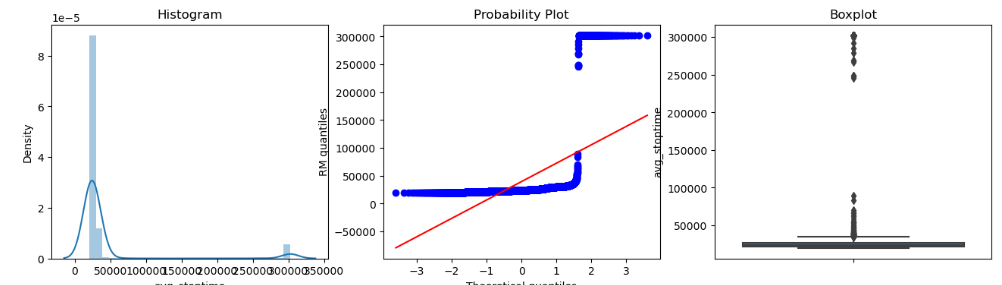


In [43]:
# diagnostic_plots(df_t, 'avg_lap_time')

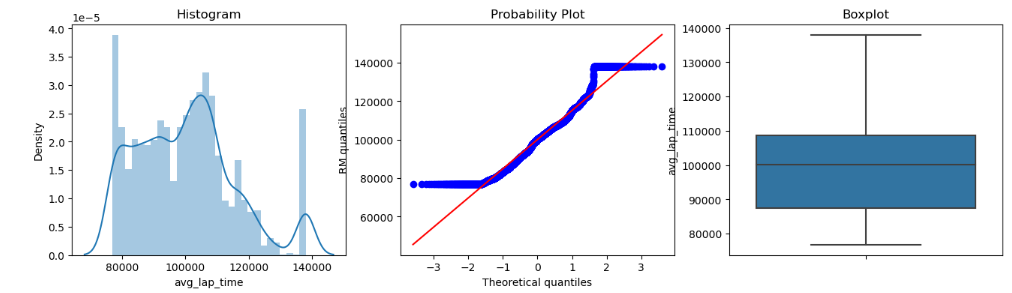

In [44]:
# we can inspect the minimum caps for each variable
# windsorizer.left_tail_caps_

In [45]:
# # we can inspect the maximum caps for each variable
# windsorizer.right_tail_caps_

#### Capping (Gaussian)

In [46]:
# df2 =df #trial

In [47]:
# windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
#                           tail='right', # cap left, right or both tails 
#                           fold=3,
#                           variables=['avg_stoptime', 'avg_lap_time'])

# windsorizer.fit(df2)

In [48]:
# df2 = windsorizer.transform(df2)

In [49]:
# # we can inspect the minimum caps for each variable
# windsorizer.left_tail_caps_

In [50]:
# # we can inspect the maximum caps for each variable
# windsorizer.right_tail_caps_

In [51]:
# # boxplot for outliers
# plt.figure(figsize=(3,6))
# sns.boxplot(y=df2['avg_stoptime'])
# plt.title('avg_stoptime Boxplot')

In [52]:
# # boxplot for outliers
# plt.figure(figsize=(3,6))
# sns.boxplot(y=df2['avg_lap_time'])
# plt.title('avg_lap_time Boxplot')

#### Capping (IQR)

In [53]:
# Function used to view the distribution of the variable (numerical ones)

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [54]:
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='right', # cap left, right or both tails 
                          fold=3,
                          variables=['avg_stoptime', 'avg_lap_time'])
windsorizer.fit(df)

Winsorizer(capping_method='iqr', variables=['avg_stoptime', 'avg_lap_time'])

In [55]:
df = windsorizer.transform(df)

In [56]:
# we can inspect the minimum caps for each variable
windsorizer.left_tail_caps_

{}

In [57]:
# we can inspect the maximum caps for each variable
windsorizer.right_tail_caps_

{'avg_stoptime': 42343.875, 'avg_lap_time': 171633.4807006719}

Text(0.5, 1.0, 'avg_stoptime Boxplot')

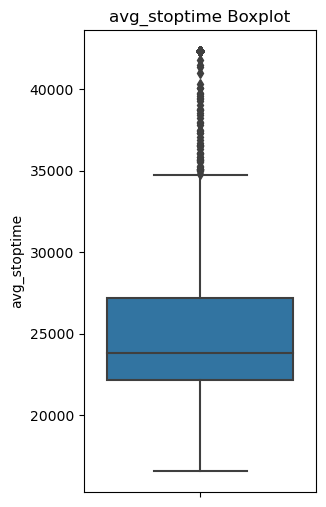

In [58]:
# boxplot for outliers
plt.figure(figsize=(3,6))
sns.boxplot(y=df['avg_stoptime'])
plt.title('avg_stoptime Boxplot')

Text(0.5, 1.0, 'avg_lap_time Boxplot')

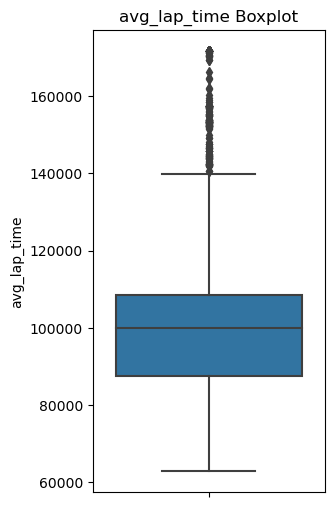

In [59]:
# boxplot for outliers
plt.figure(figsize=(3,6))
sns.boxplot(y=df['avg_lap_time'])
plt.title('avg_lap_time Boxplot')

#### Capping (Quartiles)

In [60]:
# windsorizer = Winsorizer(capping_method='quantiles', # choose iqr for skewed or gaussian for normal
#                           tail='right', # cap left, right or both tails 
#                           fold=0.05,
#                           variables=['avg_stoptime', 'avg_lap_time'])

# windsorizer.fit(df)

In [61]:
# df = windsorizer.transform(df)

In [62]:
# # we can inspect the minimum caps for each variable
# windsorizer.left_tail_caps_

In [63]:
# # we can inspect the maximum caps for each variable
# windsorizer.right_tail_caps_

In [64]:
# # boxplot for outliers
# plt.figure(figsize=(3,6))
# sns.boxplot(y=df['avg_stoptime'])
# plt.title('avg_stoptime Boxplot')

In [65]:
# # boxplot for outliers
# plt.figure(figsize=(3,6))
# sns.boxplot(y=df['avg_lap_time'])
# plt.title('avg_lap_time Boxplot')

#### Zero Coding - Not Performed

### Numerical Transformation

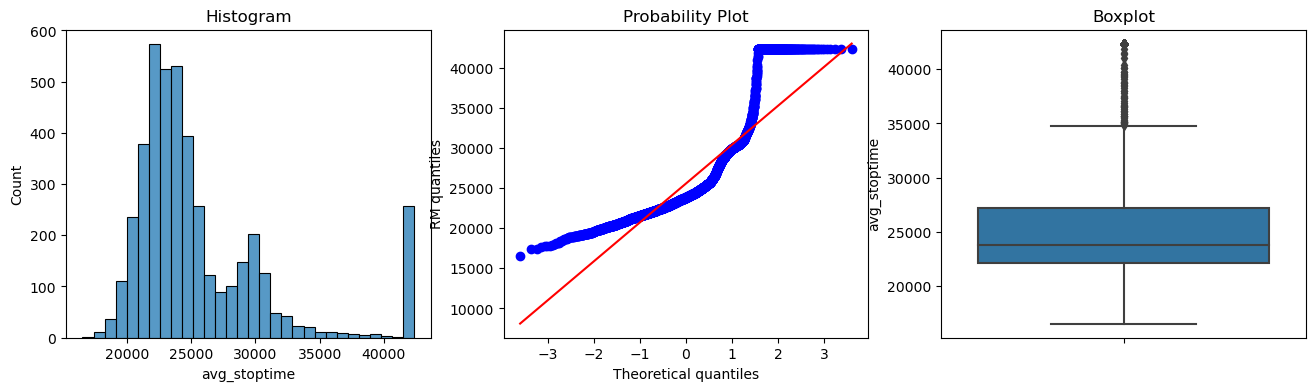

In [66]:
#Before Numerical Transformation : avg_stoptime
diagnostic_plots(df, 'avg_stoptime')


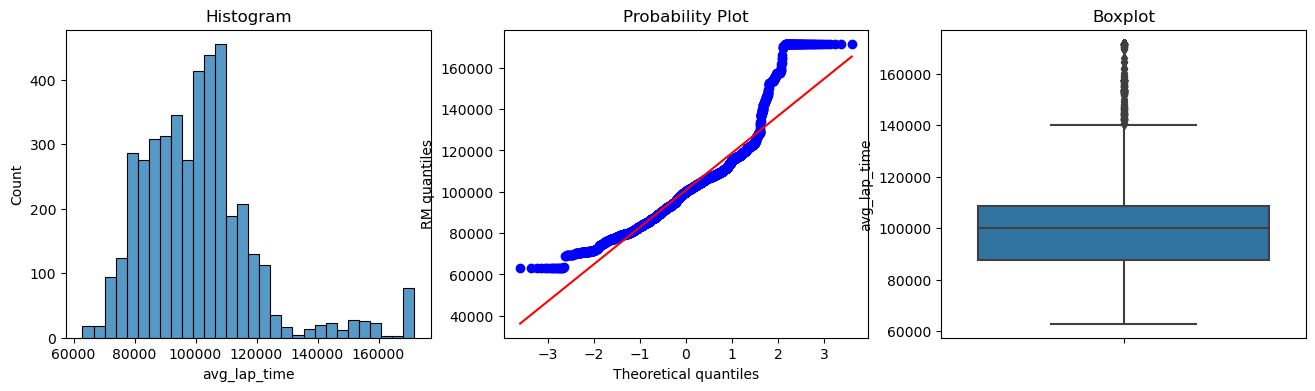

In [67]:
#Before Numerical Transformation : avg_lap_time
diagnostic_plots(df, 'avg_lap_time')

#### logarithmic transformation

In [68]:
# # initialize the transformer
# lt = LogTransformer(variables=['avg_stoptime','avg_lap_time'])

# # fit transformer to data set
# lt.fit(df)

In [69]:
# # transform variables within our data set
# transformed_df = lt.transform(df)

In [70]:
# diagnostic_plots(transformed_df, 'avg_stoptime')

In [71]:
# diagnostic_plots(transformed_df, 'avg_lap_time')

#### Reciprocal Transformation

In [72]:
# initialize the transformer
rt = ReciprocalTransformer(variables = ['avg_stoptime','avg_lap_time'])

# fit transformer to the entire dataframe
rt.fit(df)

ReciprocalTransformer(variables=['avg_stoptime', 'avg_lap_time'])

In [73]:
# transform the indicated variables within our data set
df2 = rt.transform(df)

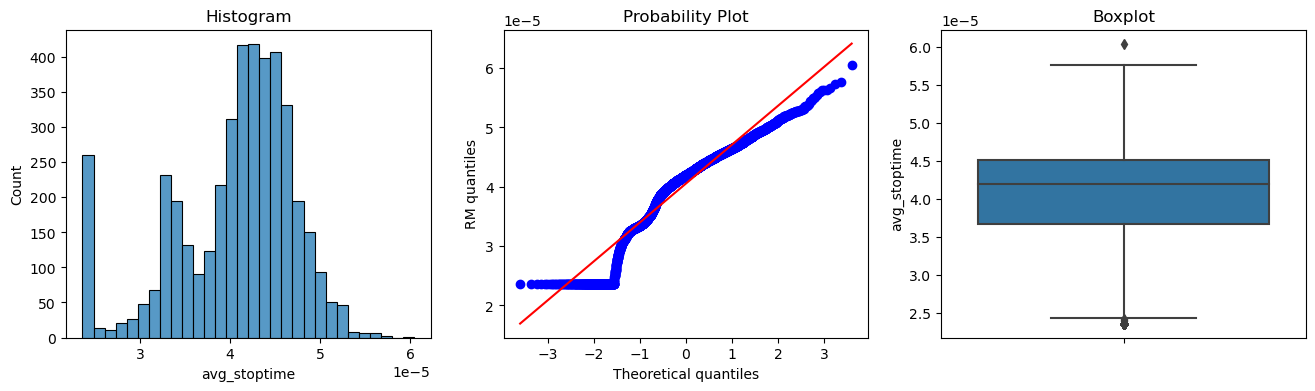

In [74]:
# use diagnostic plot function to evaluate transformation
diagnostic_plots(df2, 'avg_stoptime')

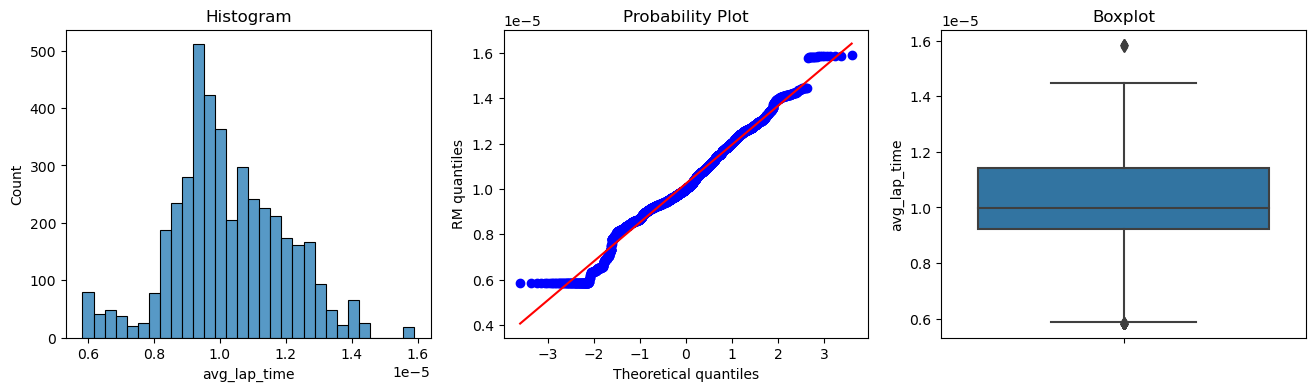

In [75]:
diagnostic_plots(df2, 'avg_lap_time')

#### Square Root Transformation

In [76]:
# # set up PowerTransformer with the square root exponent
# et = PowerTransformer(variables = ['avg_stoptime','avg_lap_time'], exp=1/2) # for cube root

# # fit transformer to data 
# et.fit(df)

In [77]:
# # transform indicated variables within our dataframe
# df3 = et.transform(df)

In [78]:
# diagnostic_plots(df3, 'avg_stoptime')

In [79]:
# diagnostic_plots(df3, 'avg_lap_time')

#### Cube Root Transformation

In [80]:
# # set up PowerTransformer with the square root exponent
# et = PowerTransformer(variables = ['avg_stoptime','avg_lap_time'], exp=1/3) # for cube root

# # fit transformer to data 
# et.fit(df)

In [81]:
# # transform indicated variables within our dataframe
# df4 = et.transform(df)

In [82]:
# diagnostic_plots(df4, 'avg_stoptime')

In [83]:
# diagnostic_plots(df4, 'avg_lap_time')

#### Power Transformation

In [84]:
# # initialize the transformer with the variables to transform and 
# # the desired exponent

# et = PowerTransformer(variables = ['avg_stoptime','avg_lap_time'], exp=0.3)

# # fit transformer to data
# et.fit(df)

In [85]:
# # transform indicated variables within our dataframe
# df5 = et.transform(df)

In [86]:
# diagnostic_plots(df5, 'avg_stoptime')

In [87]:
# diagnostic_plots(df5, 'avg_lap_time')

#### Box Cox Transformation

In [88]:
# initialize the transformer with a group of variables to transform
bct = BoxCoxTransformer(variables = ['avg_stoptime','avg_lap_time'])

# fit transformer to the data set
bct.fit(df)

BoxCoxTransformer(variables=['avg_stoptime', 'avg_lap_time'])

In [89]:
df6 = bct.transform(df)

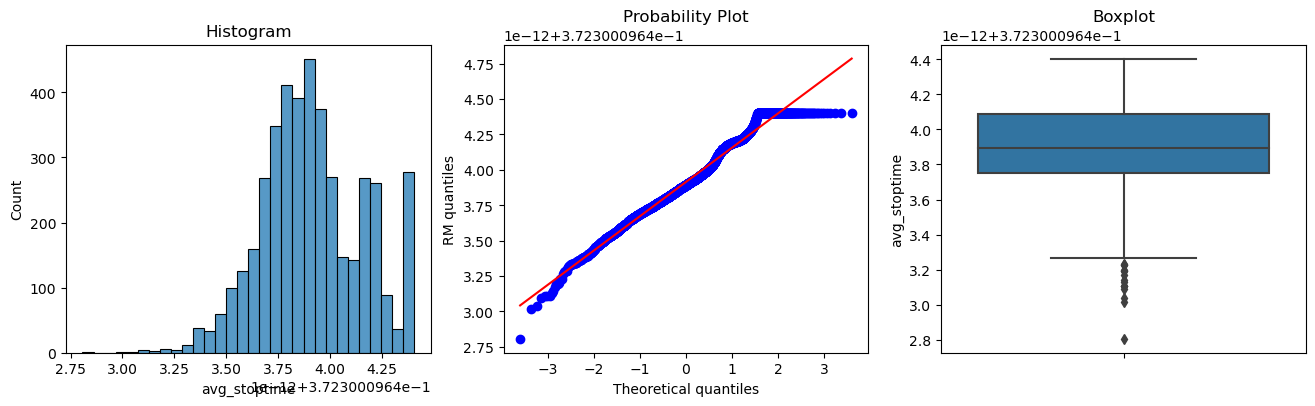

In [90]:
diagnostic_plots(df6, 'avg_stoptime')

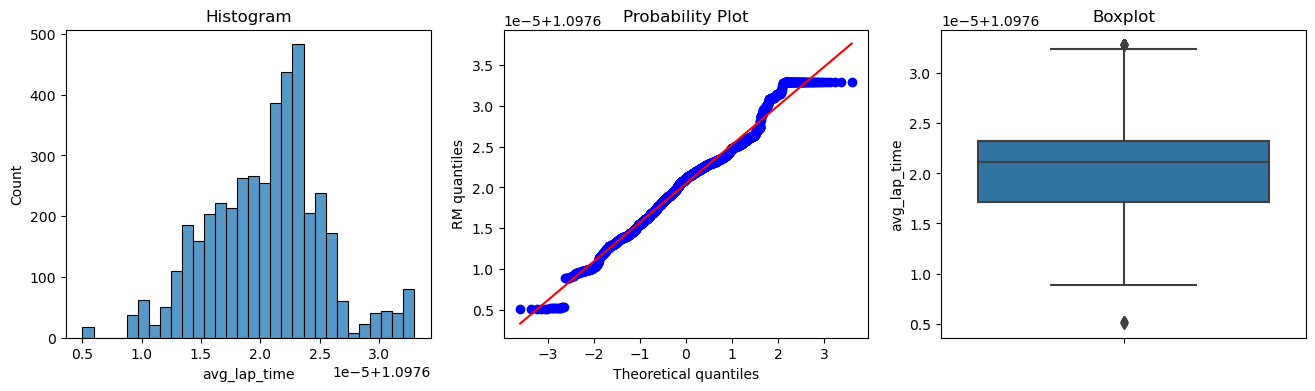

In [91]:
diagnostic_plots(df6, 'avg_lap_time')

#### Yeo Johnson Transformation

In [92]:
# initialize the transformer with a group of variables to transform
yjt = YeoJohnsonTransformer(variables = ['avg_stoptime','avg_lap_time'])

# fit transformer to the data set
yjt.fit(df)

YeoJohnsonTransformer(variables=['avg_stoptime', 'avg_lap_time'])

In [93]:
df7 = yjt.transform(df)

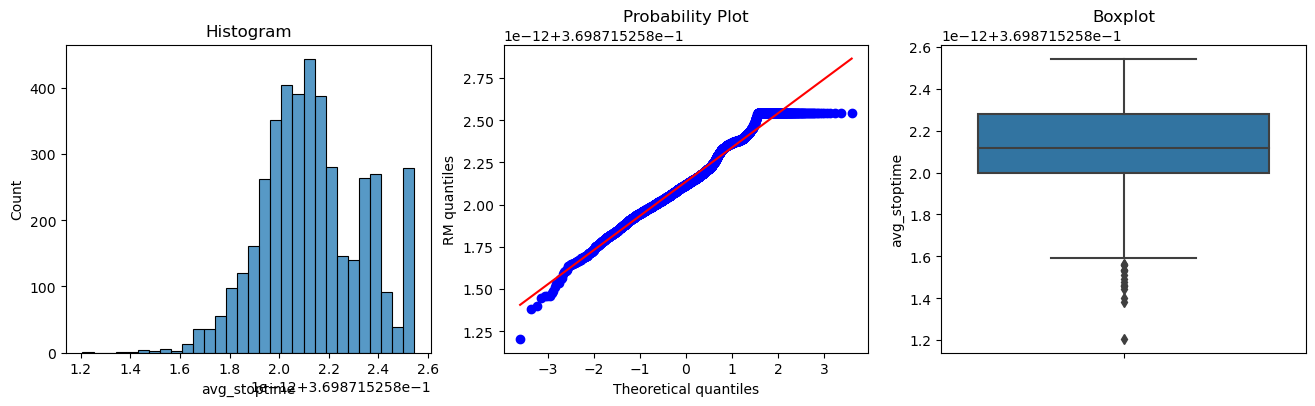

In [94]:
diagnostic_plots(df7, 'avg_stoptime')

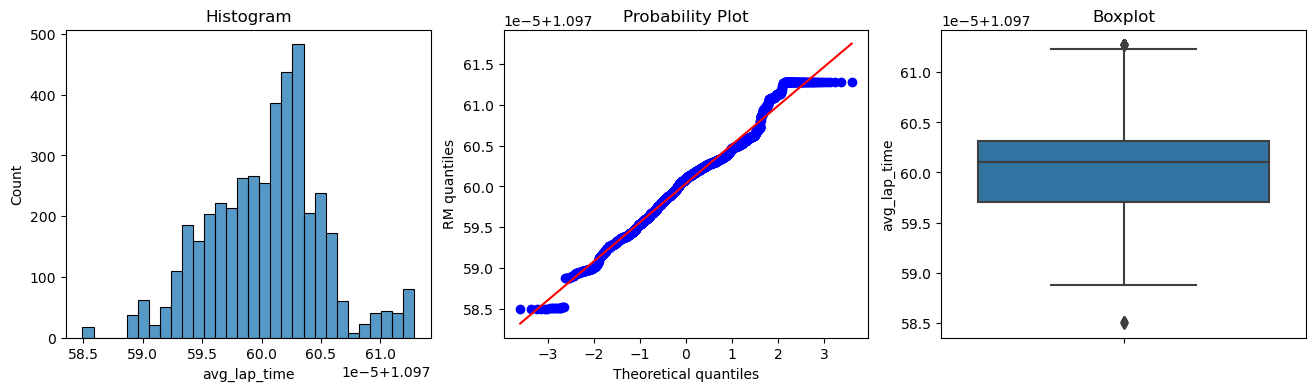

In [95]:
diagnostic_plots(df7, 'avg_lap_time')

#### Train Test Split

- X_train & y_train : 2997 rows  
- X_test & y_test : 1285 rows 
- X_train & X_test : 11 columns  (1 missing column due to target variable result)

Note: Using df7 as the dataframe as YeoJohnson Transformation results in the most normaly distributed plot. Can be changed to other dataframes by using different df_ numbers

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    df7.drop(labels=['result'], axis=1),  # predictors
    df7['result'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0) # seed to ensure reproducibility

In [97]:
X_train

,grid,laps,rank,statusId,driver_origin,race_location,avg_lap_time,no_stops,avg_stoptime,driver_name,driver_age
926,5,78,4,1,Australian,Monaco,1.09759,1,0.36987,Daniel Ricciardo,28
243,14,56,13,1,British,Malaysia,1.09760,3,0.36987,Paul di Resta,25
3897,10,70,13,11,Brazilian,Mexico,1.09760,1,0.36987,Felipe Massa,36
3911,10,71,9,1,German,Mexico,1.09760,2,0.36987,Nico Hülkenberg,28
673,18,21,21,36,Dutch,Spain,1.09760,2,0.36987,Giedo van der Garde,28
...,...,...,...,...,...,...,...,...,...,...,...
1036,10,69,11,11,Finnish,Canada,1.09759,1,0.36987,Kimi Räikkönen,34
3271,7,55,10,1,French,Korea,1.09760,2,0.36987,Romain Grosjean,26
1657,11,69,7,11,Australian,Hungary,1.09760,2,0.36987,Daniel Ricciardo,31
2612,21,70,14,11,German,Brazil,1.09760,4,0.36987,Timo Glock,30


In [98]:
y_train

926     1
243     0
3897    0
3911    1
673     0
       ..
1036    0
3271    1
1657    1
2612    0
2737    1
Name: result, Length: 2997, dtype: int64

In [99]:
X_test

,grid,laps,rank,statusId,driver_origin,race_location,avg_lap_time,no_stops,avg_stoptime,driver_name,driver_age
2775,2,60,2,1,British,Germany,1.09760,2,0.36987,Lewis Hamilton,35
1987,2,53,1,1,British,Italy,1.09760,2,0.36987,Lewis Hamilton,26
1045,21,56,22,22,German,Canada,1.09760,1,0.36987,Timo Glock,30
1522,10,27,16,3,Monegasque,Germany,1.09760,3,0.36987,Charles Leclerc,22
1829,6,43,12,11,Finnish,Belgium,1.09761,3,0.36987,Kimi Räikkönen,40
...,...,...,...,...,...,...,...,...,...,...,...
2444,9,56,1,1,German,China,1.09760,3,0.36987,Sebastian Vettel,26
3867,1,53,1,1,British,Russia,1.09760,2,0.36987,Lando Norris,22
430,2,57,4,1,Finnish,Bahrain,1.09761,4,0.36987,Valtteri Bottas,31
2388,7,56,6,1,British,China,1.09760,3,0.36987,Lewis Hamilton,27


In [100]:
y_test

2775    1
1987    1
1045    0
1522    0
1829    0
       ..
2444    1
3867    1
430     1
2388    1
3747    1
Name: result, Length: 1285, dtype: int64

### Categorical Encoding
    

##### One Hot Encoding

In [101]:
# let's create the encoder
ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

ohe_enc.fit(X_train)

OneHotEncoder(drop_last=True)

In [102]:
# we can see which variables the encoder will encode

ohe_enc.variables

In [103]:
# let's transform train and test set

X_train_enc = ohe_enc.transform(X_train)
X_test_enc = ohe_enc.transform(X_test)

C:\Users\ICT Student-07\anaconda3\Lib\site-packages\feature_engine\encoding\one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
C:\Users\ICT Student-07\anaconda3\Lib\site-packages\feature_engine\encoding\one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
C:\Users\ICT Student-07\anaconda3\Lib\site-packages\feature_engine\encoding\one_hot.py:277: PerformanceWarning: DataFrame 

In [104]:
# let's transform train and test sets
X_train_enc.head()

,grid,laps,avg_lap_time,no_stops,avg_stoptime,driver_age,rank_4,rank_13,rank_9,rank_21,...,driver_name_Yuki Tsunoda,driver_name_Michael Schumacher,driver_name_Roberto Merhi,driver_name_Nick Heidfeld,driver_name_Max Chilton,driver_name_Vitantonio Liuzzi,driver_name_Jack Aitken,driver_name_Rio Haryanto,driver_name_Pedro de la Rosa,driver_name_Karun Chandhok
926,5,78,1.09759,1,0.36987,28,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,14,56,1.09760,3,0.36987,25,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3897,10,70,1.09760,1,0.36987,36,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3911,10,71,1.09760,2,0.36987,28,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
673,18,21,1.09760,2,0.36987,28,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [105]:
X_test_enc.head()

,grid,laps,avg_lap_time,no_stops,avg_stoptime,driver_age,rank_4,rank_13,rank_9,rank_21,...,driver_name_Yuki Tsunoda,driver_name_Michael Schumacher,driver_name_Roberto Merhi,driver_name_Nick Heidfeld,driver_name_Max Chilton,driver_name_Vitantonio Liuzzi,driver_name_Jack Aitken,driver_name_Rio Haryanto,driver_name_Pedro de la Rosa,driver_name_Karun Chandhok
2775,2,60,1.09760,2,0.36987,35,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1987,2,53,1.09760,2,0.36987,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1045,21,56,1.09760,1,0.36987,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1522,10,27,1.09760,3,0.36987,22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1829,6,43,1.09761,3,0.36987,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- The LogReg Model's accuracy on train data is 89.89%.
- The LogReg Model's accuracy on test data is 86.23%.
- The Naive Baseline Model's accuracy on train data is 60.16%.
- The Naive Baseline Model's accuracy on test data is 57.90%.

#### Ordinal encoding (Arbitrary and Ordered)

In [106]:
# cat_cols = [c for c in df7.columns if df7[c].dtypes=='O'] 
# df[cat_cols].head()

In [107]:
# # for integer encoding using feature-engine

# ordinal_enc = OrdinalEncoder(
#     encoding_method='arbitrary',
#     variables=cat_cols)


In [108]:
# # For ordered ordinal Encoding
# ordinal_enc = OrdinalEncoder(
#     encoding_method='ordered')

In [109]:
# # let's fit the encoder to the train set
# ordinal_enc.fit(X_train)

In [110]:
# # let's inspect which variables the encoder will encode

# ordinal_enc.variables

In [111]:
# # in the encoder dict we can observe the numbers
# # assigned to each category for all the indicated variables

# ordinal_enc.encoder_dict_

In [112]:
# # let's transform the train and test sets

# X_train_enc = ordinal_enc.transform(X_train)
# X_test_enc = ordinal_enc.transform(X_test)

In [113]:
# # let's explore the result

# X_train.head()

Ordinal Encoding resuls in null values being returned, thus fitting cannot be performed and Ordinal Encoding wasnt chosen as my Encoding method.

#### Count Frequency Encoder

In [114]:
# # let's create an encoder

# count_enc = CountFrequencyEncoder(
#     encoding_method='frequency', # to do frequency ==> encoding_method='frequency'
#     variables=None)

In [115]:
# # fit the encoder to the train set
# count_enc.fit(X_train)

In [116]:
# # the encoder stores the variables it will encode

# count_enc.variables

In [117]:
# # in the encoder dict contains the counts or frequencies
# # per category per variable

# count_enc.encoder_dict_

In [118]:
# # let's transform train and test sets

# X_train_enc = count_enc.transform(X_train)
# X_test_enc = count_enc.transform(X_test)

In [119]:
# # let's inspect the result

# X_train_enc.head()

In [120]:
# X_test_enc.head()

- Resulted in Null values in StatusId, thus logistic regression couldnt be performed. (both for Count and Frequency encoding methods)

#### Target Mean Encoding

In [121]:
# mean_enc = MeanEncoder(variables=None)

In [122]:
# mean_enc.fit(X_train, y_train)

In [123]:
# mean_enc.variables

In [124]:
# mean_enc.encoder_dict_

In [125]:
# X_train_enc = mean_enc.transform(X_train)
# X_test_enc = mean_enc.transform(X_test)

In [126]:
# X_train_enc.head()

- Resulted in Null values in StatusId, thus Target Mean regression couldnt be performed.

### Discretisation


#### Equal Frequency Discretisation

In [127]:
disc = EqualFrequencyDiscretiser(q=10, variables =['grid', 'laps', 'avg_lap_time','no_stops','avg_stoptime','driver_age'])

disc.fit(X_train_enc)

EqualFrequencyDiscretiser(variables=['grid', 'laps', 'avg_lap_time', 'no_stops',
                                     'avg_stoptime', 'driver_age'])

In [128]:
disc.binner_dict_

{'grid': [-inf, 2.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, inf],
 'laps': [-inf, 44.0, 52.0, 53.0, 55.0, 56.0, 58.0, 64.0, 69.0, 70.0, inf],
 'avg_lap_time': [-inf,
  1.0975940234375026,
  1.097596251760515,
  1.0975980861825019,
  1.0975995106541205,
  1.0976010926689879,
  1.0976020465176513,
  1.0976028561859272,
  1.097603774299623,
  1.0976056201531468,
  inf],
 'no_stops': [-inf, 2.0, 3.0, inf],
 'avg_stoptime': [-inf,
  0.36987152580190075,
  0.36987152580197596,
  0.36987152580202476,
  0.36987152580207483,
  0.3698715258021186,
  0.3698715258021648,
  0.36987152580222793,
  0.3698715258023446,
  0.3698715258024107,
  inf],
 'driver_age': [-inf,
  22.0,
  23.0,
  24.0,
  26.0,
  27.0,
  28.0,
  30.0,
  32.0,
  35.0,
  inf]}

In [129]:
train_t = disc.transform(X_train_enc)
test_t = disc.transform(X_test_enc)

Text(0, 0.5, 'Number of observations per bin')

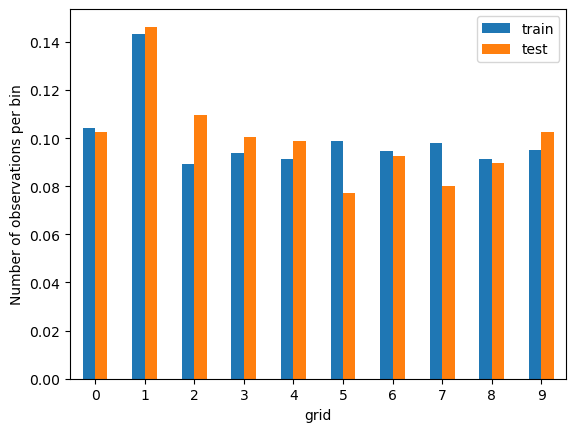

In [130]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set

# points

t1 = train_t.groupby(['grid'])['grid'].count() / len(train_t)
t2 = test_t.groupby(['grid'])['grid'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

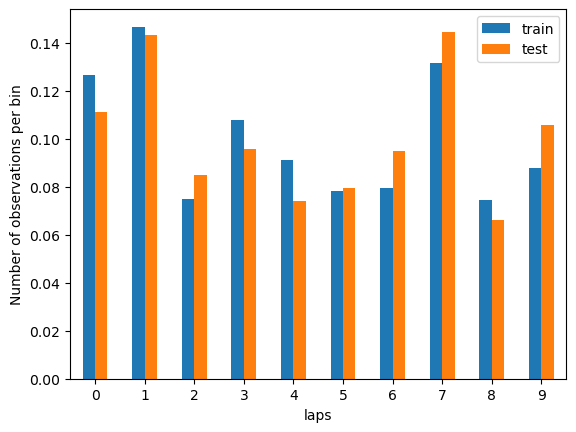

In [131]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set

# laps

t1 = train_t.groupby(['laps'])['laps'].count() / len(train_t)
t2 = test_t.groupby(['laps'])['laps'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

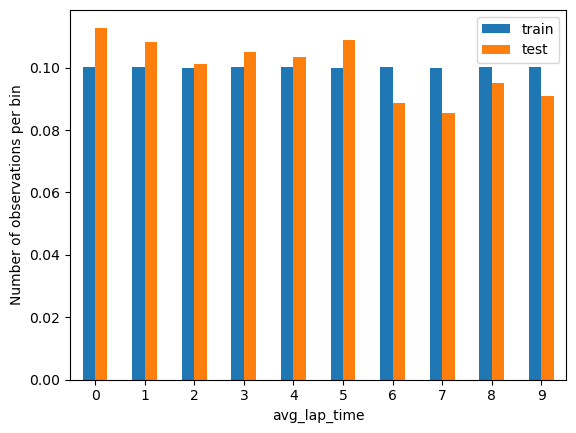

In [132]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set

# avg_lap_time

t1 = train_t.groupby(['avg_lap_time'])['avg_lap_time'].count() / len(train_t)
t2 = test_t.groupby(['avg_lap_time'])['avg_lap_time'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

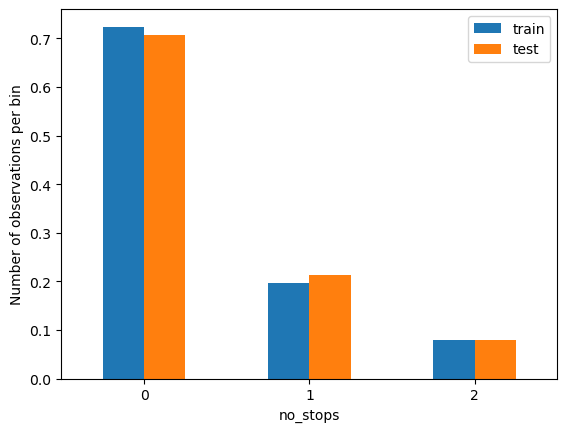

In [133]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set

# no_stops

t1 = train_t.groupby(['no_stops'])['no_stops'].count() / len(train_t)
t2 = test_t.groupby(['no_stops'])['no_stops'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

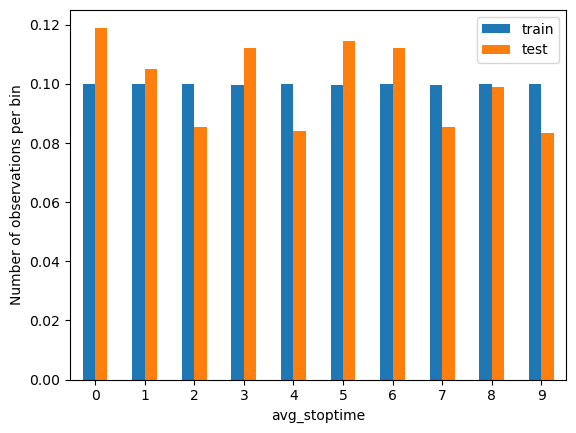

In [134]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set

# avg_stoptime

t1 = train_t.groupby(['avg_stoptime'])['avg_stoptime'].count() / len(train_t)
t2 = test_t.groupby(['avg_stoptime'])['avg_stoptime'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

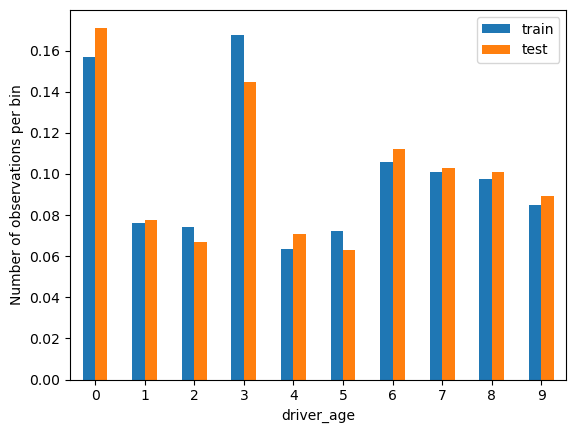

In [135]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set

# driver_age

t1 = train_t.groupby(['driver_age'])['driver_age'].count() / len(train_t)
t2 = test_t.groupby(['driver_age'])['driver_age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

- The LogReg Model's accuracy on train data is 89.86%.
- The LogReg Model's accuracy on test data is 85.76%
- The Naive Baseline Model's accuracy on train data is 60.16%.
- The Naive Baseline Model's accuracy on test data is 57.90%.

#### Equal Width Discretisation

In [136]:
# # with feature engine we can automate the process for many variables
# # in one line of code

# disc = EqualWidthDiscretiser(bins=10, variables = ['grid', 'laps', 'avg_lap_time','no_stops','avg_stoptime','driver_age'])

# disc.fit(X_train_enc)

In [137]:
# disc.binner_dict_

In [138]:
# train_t = disc.transform(X_train_enc)
# test_t = disc.transform(X_test_enc)

In [139]:
# # grid
# t1 = train_t.groupby(['grid'])['grid'].count() / len(train_t)
# t2 = test_t.groupby(['grid'])['grid'].count() / len(test_t)

# tmp = pd.concat([t1, t2], axis=1)
# tmp.columns = ['train', 'test']
# tmp.plot.bar()
# plt.xticks(rotation=0)
# plt.ylabel('Number of observations per bin')

In [140]:
# # laps
# t1 = train_t.groupby(['laps'])['laps'].count() / len(train_t)
# t2 = test_t.groupby(['laps'])['laps'].count() / len(test_t)

# tmp = pd.concat([t1, t2], axis=1)
# tmp.columns = ['train', 'test']
# tmp.plot.bar()
# plt.xticks(rotation=0)
# plt.ylabel('Number of observations per bin')

In [141]:
# # avg_lap_time
# t1 = train_t.groupby(['avg_lap_time'])['avg_lap_time'].count() / len(train_t)
# t2 = test_t.groupby(['avg_lap_time'])['avg_lap_time'].count() / len(test_t)

# tmp = pd.concat([t1, t2], axis=1)
# tmp.columns = ['train', 'test']
# tmp.plot.bar()
# plt.xticks(rotation=0)
# plt.ylabel('Number of observations per bin')

In [142]:
# # no_stops
# t1 = train_t.groupby(['no_stops'])['no_stops'].count() / len(train_t)
# t2 = test_t.groupby(['no_stops'])['no_stops'].count() / len(test_t)

# tmp = pd.concat([t1, t2], axis=1)
# tmp.columns = ['train', 'test']
# tmp.plot.bar()
# plt.xticks(rotation=0)
# plt.ylabel('Number of observations per bin')

In [143]:
# # avg_stoptime
# t1 = train_t.groupby(['avg_stoptime'])['avg_stoptime'].count() / len(train_t)
# t2 = test_t.groupby(['avg_stoptime'])['avg_stoptime'].count() / len(test_t)

# tmp = pd.concat([t1, t2], axis=1)
# tmp.columns = ['train', 'test']
# tmp.plot.bar()
# plt.xticks(rotation=0)
# plt.ylabel('Number of observations per bin')

In [144]:
# # driver_age
# t1 = train_t.groupby(['driver_age'])['driver_age'].count() / len(train_t)
# t2 = test_t.groupby(['driver_age'])['driver_age'].count() / len(test_t)

# tmp = pd.concat([t1, t2], axis=1)
# tmp.columns = ['train', 'test']
# tmp.plot.bar()
# plt.xticks(rotation=0)
# plt.ylabel('Number of observations per bin')

- The LogReg Model's accuracy on train data is 89.62%.
- The LogReg Model's accuracy on test data is 85.84%.
- The Naive Baseline Model's accuracy on train data is 60.16%.
- The Naive Baseline Model's accuracy on test data is 57.90%.

#### Discretization followed by Categorical encoding

In [145]:
# disc = EqualFrequencyDiscretiser(
#     q=10, variables=['grid', 'laps', 'avg_lap_time','no_stops','avg_stoptime','driver_age'], return_object=True)

# disc.fit(X_train_enc)


In [146]:
# X_train_enc.dtypes

In [147]:
# # transform train and test

# train_t = disc.transform(X_train_enc)
# test_t = disc.transform(X_test_enc)

In [148]:
# train_t.dtypes

In [149]:
# train_t[['grid', 'laps', 'avg_lap_time','no_stops','avg_stoptime','driver_age']]

In [150]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('grid')['result'].mean().plot()
# plt.ylabel('Mean of grid')

In [151]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('laps')['result'].mean().plot()
# plt.ylabel('Mean of laps')

In [152]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('avg_lap_time')['result'].mean().plot()
# plt.ylabel('Mean of avg_lap_time')

In [153]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('no_stops')['result'].mean().plot()
# plt.ylabel('Mean of no_stops')

In [154]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('avg_stoptime')['result'].mean().plot()
# plt.ylabel('Mean of avg_stoptime')

In [155]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('driver_age')['result'].mean().plot()
# plt.ylabel('Mean of driver_age')

In [156]:
# # let's order the bins

# enc = OrdinalEncoder(encoding_method = 'ordered')

# enc.fit(train_t, y_train)

In [157]:
# # we can fnd the list of encoded variables here
# enc.variables

In [158]:
# # we can find a list of the re-ordered bins mappings here
# enc.encoder_dict_

In [159]:
# # let's transformt the data sets
# train_t = enc.transform(train_t)
# test_t = enc.transform(test_t)

In [160]:
# train_t[['grid', 'laps', 'avg_lap_time','no_stops','avg_stoptime','driver_age']]

In [161]:
# # let's explore the monotonic relationship between bins and target

# pd.concat([train_t, y_train], axis=1).groupby('grid')['result'].mean().plot()
# plt.ylabel('mean of grid')

In [162]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('laps')['result'].mean().plot()
# plt.ylabel('Mean of laps')

In [163]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('avg_lap_time')['result'].mean().plot()
# plt.ylabel('Mean of avg_lap_time')

In [164]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('no_stops')['result'].mean().plot()
# plt.ylabel('Mean of no_stops')

In [165]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('avg_stoptime')['result'].mean().plot()
# plt.ylabel('Mean of avg_stoptime')

In [166]:
# # let's explore if the bins have a linear relationship
# # with the target: we see they don't

# pd.concat([train_t, y_train], axis=1).groupby('driver_age')['result'].mean().plot()
# plt.ylabel('Mean of driver_age')

- The LogReg Model's accuracy on train data is 89.52%.
- The LogReg Model's accuracy on test data is 85.68%.
- The Naive Baseline Model's accuracy on train data is 60.16%.
- The Naive Baseline Model's accuracy on test data is 57.90%.

### Feature Scaling

#### Robust Scaling

In [167]:
# set up the scaler
scaler = RobustScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(train_t)

# transform train and test sets
train_t_scaled = scaler.transform(train_t)
test_t_scaled = scaler.transform(test_t)

In [168]:
# the scaler stores the median values of the features as learned from train set
scaler.center_

array([4., 4., 4., 0., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [169]:
# the scaler stores the IQR values of the features as learned from train set

scaler.scale_

array([5., 6., 5., 1., 5., 5., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [170]:
# let's transform the returned NumPy arrays to dataframes
train_t_scaled = pd.DataFrame(train_t_scaled, columns=train_t.columns)
test_t_scaled = pd.DataFrame(test_t_scaled, columns=test_t.columns)

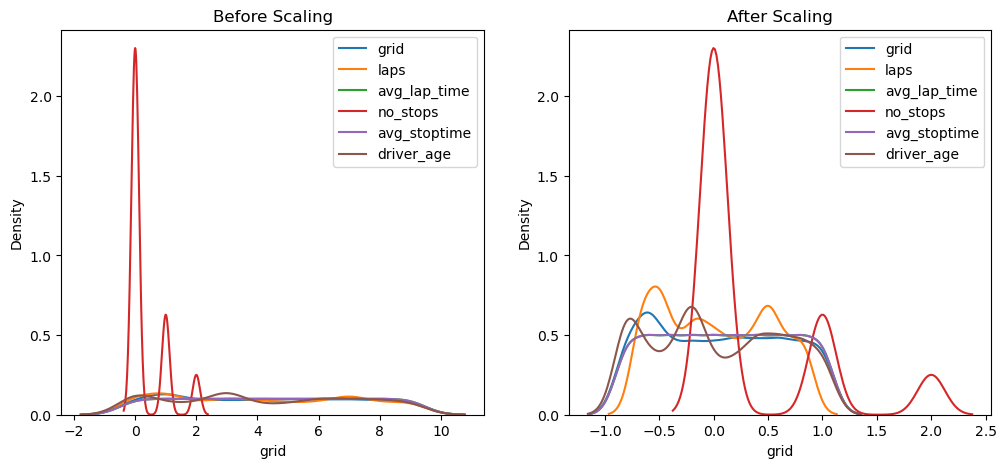

In [171]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(train_t['grid'], ax=ax1, label ='grid')
sns.kdeplot(train_t['laps'], ax=ax1, label ='laps')
sns.kdeplot(train_t['avg_lap_time'], ax=ax1, label ='avg_lap_time')
sns.kdeplot(train_t['no_stops'], ax=ax1, label ='no_stops')
sns.kdeplot(train_t['avg_stoptime'], ax=ax1, label ='avg_stoptime')
sns.kdeplot(train_t['driver_age'], ax=ax1, label ='driver_age')

ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(train_t_scaled['grid'], ax=ax2, label ='grid')
sns.kdeplot(train_t_scaled['laps'], ax=ax2, label ='laps')
sns.kdeplot(train_t_scaled['avg_lap_time'], ax=ax2, label ='avg_lap_time')
sns.kdeplot(train_t_scaled['no_stops'], ax=ax2, label ='no_stops')
sns.kdeplot(train_t_scaled['avg_stoptime'], ax=ax2, label ='avg_stoptime')
sns.kdeplot(train_t_scaled['driver_age'], ax=ax2, label ='driver_age')

ax2.legend()
plt.show()

In [172]:
train_t_scaled.shape, test_t_scaled.shape

((2997, 201), (1285, 201))

- The LogReg Model's accuracy on train data is 89.82%.
- The LogReg Model's accuracy on test data is 85.60%.
- The Naive Baseline Model's accuracy on train data is 60.16%.
- The Naive Baseline Model's accuracy on test data is 57.90%.

#### Standardisation

In [173]:
# # standardisation: with the StandardScaler from sklearn

# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(train_t)

# # transform train and test sets
# train_t_scaled = scaler.transform(train_t)
# test_t_scaled = scaler.transform(test_t)

In [174]:
# # the scaler stores the mean of the features, learned from train set
# scaler.mean_

In [175]:
# # the scaler stores the standard deviation deviation of the features,
# # learned from train set

# scaler.scale_

In [176]:
# # let's transform the returned NumPy arrays to dataframes

# train_t_scaled = pd.DataFrame(train_t_scaled, columns=train_t.columns)
# test_t_scaled = pd.DataFrame(test_t_scaled, columns=test_t.columns)

In [177]:
# # let's compare the variable distributions before and after scaling


# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# # before scaling
# ax1.set_title('Before Scaling')
# sns.kdeplot(train_t['grid'], ax=ax1, label ='grid')
# sns.kdeplot(train_t['laps'], ax=ax1, label ='laps')
# sns.kdeplot(train_t['avg_lap_time'], ax=ax1, label ='avg_lap_time')
# sns.kdeplot(train_t['no_stops'], ax=ax1, label ='no_stops')
# sns.kdeplot(train_t['avg_stoptime'], ax=ax1, label ='avg_stoptime')
# sns.kdeplot(train_t['driver_age'], ax=ax1, label ='driver_age')

# ax1.legend()

# # after scaling
# ax2.set_title('After Scaling')
# sns.kdeplot(train_t_scaled['grid'], ax=ax2, label ='grid')
# sns.kdeplot(train_t_scaled['laps'], ax=ax2, label ='laps')
# sns.kdeplot(train_t_scaled['avg_lap_time'], ax=ax2, label ='avg_lap_time')
# sns.kdeplot(train_t_scaled['no_stops'], ax=ax2, label ='no_stops')
# sns.kdeplot(train_t_scaled['avg_stoptime'], ax=ax2, label ='avg_stoptime')
# sns.kdeplot(train_t_scaled['driver_age'], ax=ax2, label ='driver_age')
# ax2.legend()
# plt.show()

- The LogReg Model's accuracy on train data is 89.66%.
- The LogReg Model's accuracy on test data is 85.60%.
- The Naive Baseline Model's accuracy on train data is 60.16%.
- The Naive Baseline Model's accuracy on test data is 57.90%.

#### Mean Normalisation

In [178]:
# # let's first learn the mean from the train set

# means =train_t.mean(axis=0)
# means

In [179]:
# # let's now learn the min and max values, and the value range 
# # from the train set

# ranges =train_t.max(axis=0)-train_t.min(axis=0)
# ranges

In [180]:
# # now we are ready to perform mean normalization:
# train_t_scaled = (train_t - means) / ranges
# test_t_scaled = (test_t - means) / ranges

In [181]:
# train_t_scaled

In [182]:
# # let's compare the variable distributions before and after scaling

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# # before scaling
# ax1.set_title('Before Scaling')
# sns.kdeplot(train_t['grid'], ax=ax1, label ='grid')
# sns.kdeplot(train_t['laps'], ax=ax1, label ='laps')
# sns.kdeplot(train_t['avg_lap_time'], ax=ax1, label ='avg_lap_time')
# sns.kdeplot(train_t['no_stops'], ax=ax1, label ='no_stops')
# sns.kdeplot(train_t['avg_stoptime'], ax=ax1, label ='avg_stoptime')
# sns.kdeplot(train_t['driver_age'], ax=ax1, label ='driver_age')

# ax1.legend()

# # after scaling
# ax2.set_title('After Scaling')
# sns.kdeplot(train_t_scaled['grid'], ax=ax2, label ='grid')
# sns.kdeplot(train_t_scaled['laps'], ax=ax2, label ='laps')
# sns.kdeplot(train_t_scaled['avg_lap_time'], ax=ax2, label ='avg_lap_time')
# sns.kdeplot(train_t_scaled['no_stops'], ax=ax2, label ='no_stops')
# sns.kdeplot(train_t_scaled['avg_stoptime'], ax=ax2, label ='avg_stoptime')
# sns.kdeplot(train_t_scaled['driver_age'], ax=ax2, label ='driver_age')
# ax2.legend()
# plt.show()

- The LogReg Model's accuracy on train data is 89.76%.
- The LogReg Model's accuracy on test data is 85.60%.
- The Naive Baseline Model's accuracy on train data is 60.16%.
- The Naive Baseline Model's accuracy on test data is 57.90%.

#### Min Max Scaling

In [183]:
# # set up the scaler
# scaler = MinMaxScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(train_t)

# # transform train and test sets
# train_t_scaled = scaler.transform(train_t)
# test_t_scaled = scaler.transform(test_t)

In [184]:
# # the scaler stores the maximum values of the features, learned from train set
# scaler.data_max_

In [185]:
# # the scaler stores the minimum values of the features, learned from train set
# scaler.min_

In [186]:
# # the scaler also stores the value range (max -  min)

# scaler.data_range_

In [187]:
# # let's transform the returned NumPy arrays to dataframes
# train_t_scaled = pd.DataFrame(train_t_scaled, columns=train_t.columns)
# test_t_scaled = pd.DataFrame(test_t_scaled, columns=test_t.columns)

In [188]:
# # let's compare the variable distributions before and after scaling

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# # before scaling
# ax1.set_title('Before Scaling')
# sns.kdeplot(train_t['grid'], ax=ax1, label ='grid')
# sns.kdeplot(train_t['laps'], ax=ax1, label ='laps')
# sns.kdeplot(train_t['avg_lap_time'], ax=ax1, label ='avg_lap_time')
# sns.kdeplot(train_t['no_stops'], ax=ax1, label ='no_stops')
# sns.kdeplot(train_t['avg_stoptime'], ax=ax1, label ='avg_stoptime')
# sns.kdeplot(train_t['driver_age'], ax=ax1, label ='driver_age')

# ax1.legend()

# # after scaling
# ax2.set_title('After Scaling')
# sns.kdeplot(train_t_scaled['grid'], ax=ax2, label ='grid')
# sns.kdeplot(train_t_scaled['laps'], ax=ax2, label ='laps')
# sns.kdeplot(train_t_scaled['avg_lap_time'], ax=ax2, label ='avg_lap_time')
# sns.kdeplot(train_t_scaled['no_stops'], ax=ax2, label ='no_stops')
# sns.kdeplot(train_t_scaled['avg_stoptime'], ax=ax2, label ='avg_stoptime')
# sns.kdeplot(train_t_scaled['driver_age'], ax=ax2, label ='driver_age')
# ax2.legend()
# plt.show()

- The LogReg Model's accuracy on train data is 89.79%.
- The LogReg Model's accuracy on test data is 85.76%.
- The Naive Baseline Model's accuracy on train data is 60.16%.
- The Naive Baseline Model's accuracy on test data is 57.90%.

#### Max Absolute Scaling

In [189]:
# # set up the scaler
# scaler = MaxAbsScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(train_t)

# # transform train and test sets
# train_t_scaled = scaler.transform(train_t)
# test_t_scaled = scaler.transform(test_t)

In [190]:
# # the scaler stores the maximum values of the features as learned from train set
# scaler.max_abs_

In [191]:
# # let's transform the returned NumPy arrays to dataframes 

# train_t_scaled = pd.DataFrame(train_t_scaled, columns=train_t.columns)
# test_t_scaled = pd.DataFrame(test_t_scaled, columns=test_t.columns)

In [192]:
# # let's compare the variable distributions before and after scaling

# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# # before scaling
# ax1.set_title('Before Scaling')
# sns.kdeplot(train_t['grid'], ax=ax1, label ='grid')
# sns.kdeplot(train_t['laps'], ax=ax1, label ='laps')
# sns.kdeplot(train_t['avg_lap_time'], ax=ax1, label ='avg_lap_time')
# sns.kdeplot(train_t['no_stops'], ax=ax1, label ='no_stops')
# sns.kdeplot(train_t['avg_stoptime'], ax=ax1, label ='avg_stoptime')
# sns.kdeplot(train_t['driver_age'], ax=ax1, label ='driver_age')

# ax1.legend()

# # after scaling
# ax2.set_title('After Scaling')
# sns.kdeplot(train_t_scaled['grid'], ax=ax2, label ='grid')
# sns.kdeplot(train_t_scaled['laps'], ax=ax2, label ='laps')
# sns.kdeplot(train_t_scaled['avg_lap_time'], ax=ax2, label ='avg_lap_time')
# sns.kdeplot(train_t_scaled['no_stops'], ax=ax2, label ='no_stops')
# sns.kdeplot(train_t_scaled['avg_stoptime'], ax=ax2, label ='avg_stoptime')
# sns.kdeplot(train_t_scaled['driver_age'], ax=ax2, label ='driver_age')
# ax2.legend()
# plt.show()

- The LogReg Model's accuracy on train data is 89.79%.
- The LogReg Model's accuracy on test data is 85.76%.
- The Naive Baseline Model's accuracy on train data is 60.16%.
- The Naive Baseline Model's accuracy on test data is 57.90%.

### Step 4: Machine Learning Modelling

In [207]:
train_t_scaled.shape


(2997, 201)

In [206]:
test_t_scaled.shape

(1285, 201)

In [193]:
# # Testing encoders 
# X_train = X_train_enc
# X_test = X_test_enc

In [194]:
# # Testing for discretisation
# X_train = train_t
# X_test = test_t


In [195]:
X_train = train_t_scaled
X_test = test_t_scaled

In [196]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear') # you can experiment with different combinations of multi_class and solver
# logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs') # good option for larger datasets, fails here
logreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [197]:
y_train_preds_logreg = logreg.predict(X_train)
y_test_preds_logreg = logreg.predict(X_test)

In [198]:
from sklearn.metrics import accuracy_score
# train accuracy score
y_true = y_train
y_pred = y_train_preds_logreg

train_accuracy_logreg = accuracy_score(y_true, y_pred) * 100
print(f"The LogReg Model's accuracy on train data is {train_accuracy_logreg:.2f}%.")

# test accuracy score
y_true = y_test
y_pred = y_test_preds_logreg

test_accuracy_logreg = accuracy_score(y_true, y_pred) * 100
print(f"The LogReg Model's accuracy on test data is {test_accuracy_logreg:.2f}%.")

The LogReg Model's accuracy on train data is 89.82%.
The LogReg Model's accuracy on test data is 85.60%.


#### Naive Baseline Model

In [199]:
import numpy as np
from scipy import stats

# pick the modal class from train data
print(stats.mode(y_train))

modal_class_label = stats.mode(y_train)[0]


ModeResult(mode=array([0], dtype=int64), count=array([1803]))


C:\Users\ICT Student-07\AppData\Local\Temp\ipykernel_2804\3039924124.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(stats.mode(y_train))
C:\Users\ICT Student-07\AppData\Local\Temp\ipykernel_2804\3039924124.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warnin

In [200]:
y_train_preds_naive = [int(modal_class_label) for row in X_train.iloc[:,0]]
y_train_preds_naive[0:5]

[0, 0, 0, 0, 0]

In [201]:
y_test_preds_naive = [int(modal_class_label) for row in X_test.iloc[:,0]]
y_test_preds_naive[0:5]

[0, 0, 0, 0, 0]

In [202]:
# scoring accuracy of model
# note that other metrics exist, eg. AUC-ROC, Confusion Matrix-Based Metrics, but these matter more for imbalanced data
# where classes don't share same representation, eg. class 0 is 80%, class 1 is 10%, class 2 is 10%
# and are advanced Machine Learning topics

from sklearn.metrics import accuracy_score

# train accuracy score
y_true = y_train
y_pred = y_train_preds_naive

train_accuracy_naive = accuracy_score(y_true, y_pred) * 100
print(f"The Naive Baseline Model's accuracy on train data is {train_accuracy_naive:.2f}%.")

# test accuracy score
y_true = y_test
y_pred = y_test_preds_naive

test_accuracy_naive = accuracy_score(y_true, y_pred) * 100
print(f"The Naive Baseline Model's accuracy on test data is {test_accuracy_naive:.2f}%.")

The Naive Baseline Model's accuracy on train data is 60.16%.
The Naive Baseline Model's accuracy on test data is 57.90%.


### Report

### Table of Contents

#### 1. [Introduction with Value Based Problem Statement](#part1)
#### 2. [Problem Formulation](#part2)
#### 3. [Data Wrangling ](#part3)
#### 4. [Data Cleansing and Transformation](#part4)
#### 5. [Machine Learning Model](#part5)
#### 6. [Summary](#part6)

#### Introduction with Value Based Problem Statement  <a id="part1"></a>

Using the dataset obtained through Ergast.com, exploration, cleaning and transformation will be done to create a machine learning model in hopes of prediction. In light of the upcoming Formula One World Championship's official 16th round held in Singapore, a machine learning model will be built after data wrangling techniques so as to predict results. The F1 is a race comprising of multiple qualifing rounds leading to the final race, where the last qualifying round helps in identify the driver's grid position during the final race. Since the pole position (grid = 1) is the most advantageous, competition is heavy. The grid position is among many other factors that determines the race's outcomes. 

#### Problem Formulation <a id="part2"></a>

Before getting started with data wrangling, i performed data exploration and analysis within excel, viewing the correlation between the file variables. To better relate them, I drew out a map connecting them on a piece of paper.
Within the 13 excel files, they contain information relating to the f1 races, ranging from the 1950 season till today. After analysis of the data and problem formulation, I ended up with the data tables of 'drivers_mod','lap_times_mod','pit_stops_mod','races_mod','results_mod','status_mod','circuits_mod'.

These tables were chosen based on their variables that would help with my problem prediction, where variables had to be related to the target variable.

Viewing the drivers table, it listed all the information regarding each driver, with their own respective driverId. Variables used within this table includes forename, surname - used to form the driver's name- and dob- used to form the driver's age for each race.

For the Races table, it includes all data for each race including the circuitiD - which circuit the race was held on -, the round number and date among many other variables. This was useful in problem prediction as the race conditions directly affect the driver's performance and therefore the outcome of the race - win or lose.

For the Results table it includes all the information regarding the results for each race, accompanied with the keys for the other tables of Race and Driver among others. This helps in statistical understanding of variables that impact the outocome of the race. With keys linked to the tables, it proves to be a great link to the other tables.




#### Which driver wins the race? 
Target variable: result(new variable stemming from 'position' where drivers with positions 1-8 are winners and the rest are losers). This problem statement can be brought to the real world as data analysts aim to figure out the trends behind the winners of  the races. Through this, smart bets can be placed to gain an edge in the betting community. This aligns with analysts within the stock market, where trends are explored and used to gain a betting edge.

#### Other problem statements formulated
Apart from the above problem statement, these are others that I have formulated.

What is the race time during the race? - through prediction of the timings of the race, we are able to rank our performance and from there improve on our performance respectively. This can also help identify if partaking in the competition would be worth the cost due to the high fees that come with each registration. Target variable: race time

How many points will each constructor get? - target variable: constructor points

Which nationality would come out as the victor?  - target variable: nationality 


### Data wrangling <a id="part3"></a>

In choosing my tables to work with, i chose those that have a correlation between my target variable, where the correlation is neither too small or too big. This landed me on the tables of races, results, laptime, pit_stops as well as driver

To join my tables, i used key pairings based on inner merging where the values are joined if values in both tables matches. Most of the tables were joined based on raceId and driverId except for circuit_mod which was joined based on citcuitId.
First, i merged races_mod and results_mod followed by driver_mod and circuit_mod and finally the created columns of avg_stoptime, avg_lap_time and no_stops.

To further enhance my dataset and increase the size of data for machine learning, feature engineering was performed where new columns were created. These columns include:
 - Age of driver - driver_age       
 - Name of driver - driver_name      
 - Number of pit stops -no_stops
 - Average pit stop timing - avg_stoptime     
 - Average lap time = avg_lap_time     
 
The last 3 columns - avg_lap_time,avg_stoptime and no_stops - were created through grouping their respective tables (pitstop and lap_time) by the raceId and driverId to obtain the count and the mean respectively (count for number of stops and mean for average timings). I then resetted the index to merge it to the dataframe - df.
    
For age of driver, since converting to datetime data type was not possible for date(races_mod), i had to use .str[-4:] to obtain the years - not possible due to the structure of the data as well as irregularities in the data e.g  9/4/12005. Since there were missing data in the dates(races_mod), i used bfill as all the data was either from the start of the race(first round) or in the middle of the race (middle few rounds). Thus, using bfill to fill with the date of the round after the missing date's round, we end up with the correct year. For dob(drivers_mod), i simply used .str[:4] to obtain the year as it was faster than converting to datetime and obtaining year through dt.year. Age is then finally obtained through subtracting the year from date(races) and the year from dob(drivers_mod).


Deletion of variables:

Some variables were deleted where the more notable ones include:
- Milliseconds: too highly correlated
- Points: too highly correlated

These variables were deleted based on their correlation to the target variable where I removed variables that were either too highly correlated or not correlated at all.
Most of the key columns were dropped as they did not provide any information and were used simply as links for merging the tables. StatusId was the only undropped one as it did contain information. (when status is encoded the end result would be the same )

Changes to data types were performed so that transformation can be performed smoothly. Variables of statusId and result(target variable 1/0) were changed to objects.


Finally, for the target variable, i ended with a value count of 1: 1735 (winners)and 0: 2547 (losers). (winners comprised 40.5% of the dataset). The final shape of the dataset is 4282 rows and 12 columns, whereas i started with

### Data Cleansing and Transformation <a id="part4"></a>
 

#### Outlier Handling
For outlier handling, possible methods of winsorisation, zero-coding, capping (3 forms) and trimming can be performed. Trials were performed among these methods and a final model of capping (IQR) with right tailed capping was used. Since my dataset was highly skewed, capping  was needed to be performed on the right tail to reduce the impact of the right tailed values. Trimming was not used as it would greatly reduce my dataset, with >100 rows lost. If trimming was used, a total of 4106 rows would remain, coming from 4282 rows. Zero coding was also not used as all my values are more than 0 - not in the negative. Among the 3 versions of capping - IQR, gaussian and quantile - , IQR was used as it specialises in handling skewed and extreme values, which is prominent within my dataset. Gaussian is mainly for normally distributed datasets. A final boxplot was plotted for each variable to ensure that the outliers were removed. 


#### Missing data handling
Since there were no null values in my dataset, missing data handling was not performed. Previously, missing data was found within the date column of races, which i filled using bfill (replacing with values in the row after). The number of null values/non-null values was checked using df.info(), which showed the total row number as non-null values for each column within the dataframe.
 
#### numerical transformation
For numerical transformation, i performed trials on 7 transformations and plotted it to view the impact it had. The numerical transformations include logarithmic, reciprocal, square/cube root, power, box-cox and yeojohnson transformation. Among them, 
Through the function diagnostic plot, histograms, line charts and box plot charts were plotted before and after each transformation to view the impact the transformation had. Since ___ resulted in the most normally distributed plot,_ transformation was used.

Before proceeding into categorical encoding, I had to split the dataframe into training and testing sets of 70% and 30% (the optimal ratio) respectively. This allows me to train my model and evaluate it's performance. 

#### Categorical Encoding
Following Numerical Transformation, Categorical Encoding was performed to enablethe machine learnign model to understand and extract valuable information. Among the 4 different encoding methods (and specifications) - Ordinal Encoding(ordered and arbitrary), One Hot Encoding, Target Mean and Count Frequency Encoding (count and frequency) I stuck with One Hot encoding as my final encoding method as the rest brought about null values within the statusId column. This landed me with machine learning results of:
- LogReg Model's accuracy on train data is 89.89%.
- LogReg Model's accuracy on test data is 86.23%.
- Naive Baseline Model's accuracy on train data is 60.16%.
- Naive Baseline Model's accuracy on test data is 57.90%.

#### Discretisation
Followed by Categorical Encoding, Discretisation was performed, transforming the continuous-valued variable into a discrete one by creating a set of contiguous intervals that spans the range of the variable's values. In this step, 3 discretisers were trailed, Equal Width, Equal Frequency and Discretisation plus Categorical Encoding. Through trials with the machine learning model, I landed my final discretisation method ot be Equal Width Discretisation as it yielded me the best machine learning model performance as compared to the other discretisation methods. This discretization divides the values of the variable into intervals that carry the same preportion of observations. Results of machine learning model are as follows:

 - LogReg Model's accuracy on train data is 89.86%.
 - LogReg Model's accuracy on test data is 85.76%
 - Naive Baseline Model's accuracy on train data is 60.16%.
 - Naive Baseline Model's accuracy on test data is 57.90%


#### Feature Scaling
Finally, before machine learning modelling can be performed, feature scaling is performed to reduce the biasness towards a feature, and improve the optimization process through scaling all the features to be more generalized (decreases distance between the data). For Feature Scaling i tried the methods of Standardization, Mean-normalization, Maximum Minimum Scaling, Maximum Absolute Scaling and Robust Scaling. Among which Robust Scaling was used in the final model as it results in the best machine learning model performance of:
-  LogReg Model's accuracy on train data is 89.82%.
-  LogReg Model's accuracy on test data is 85.60%.
-  Naive Baseline Model's accuracy on train data is 60.16%.
-  Naive Baseline Model's accuracy on test data is 57.90%.

### Machine Learning <a id="part5"></a>

Before plotting my model, I checked for the size of the final dataset to ensure that the size is reasonable and will not lead to unjust scores of the machine model. train_t_scaled has 2997 rows with 201 columns while test_t_scaled has 1285 rows and 201 columns.

Since my prediction problem was based on classification - target variable: result (binary) -, classification modelling was performed. After research, there were different classification methods that i could choose from, including K-nearest Neighbour, Decision Tree, Random Forest and Logistic Regression among many others. However, due to the nature of my dataset, Logistic Regression was ultimately used since it's used for understanding the influence of several independent variables on a single outcome variable (target). Apart from Logistic Regression, Naive Baseline modellign was also used - suitable for regression and classification prediction problems.

To check on my machine learning model's performance, I printed the accuracy percentage of the model, viewing its accuracy for each step within data wrangling - encoding, scaling etc - which helped me in my selection of methods to use.


### Summary <a id="part6"></a>

In conclusion, I have performed data wrangling on multiple tables, where cleaning and transformation among many other steps were performed. A prediction problem of Whether the driver won was formulated which required the creation of a new column and which classification modelling was required. Throughout data cleansing, exploration within the datasets were done within excel due to the easy view to all the data rows. This allowed me to find many data errors such as the one in races table where some years were missing and in results table where postions of 1 were wrongly identified as 99. Through data cleaning, data transformation could then be performed smoothly with numerical transformation, categorical encoding, discretization and scaling transformations were performed. Throughout transformations, comparisons were made to the machine learning model performance to aid me in choosing the right functions. Function selection was also aided by the function's use - etc does my dataset suit the specific funciton. This ultimately landed me with machine learning model results of:
 - LogReg Model's accuracy on train data is 89.82%.
 - LogReg Model's accuracy on test data is 85.60%.
 - Naive Baseline Model's accuracy on train data is 60.16%.
 - Naive Baseline Model's accuracy on test data is 57.90%.